In [1]:
%matplotlib inline

import numpy as np
import pylab as plt
import pandas as pd
from glob import glob
from astropy.io import fits
from astropy.table import Table
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Using TensorFlow backend.


In [2]:
hdul = fits.open('./data/data.fits')  # open a FITS file
data = hdul[1].data  # assume the first extension is a table
tdata = Table(data)
tdata.columns

<TableColumns names=('objID','psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z','deVRad_z','ra','dec','extinction_u','extinction_g','extinction_r','extinction_i','extinction_z','z','class')>

In [3]:
# ts=t[(t['class']=='STAR')&(t['deVRad_z']<2)]
# tg=t[(t['class']=='GALAXY')]
# tq=t[(t['class']=='QSO')&(t['deVRad_z']<2)]
print(tdata.columns)
n_objects = np.array(tdata).shape[0]

def remove_structure(x):
    return np.array(pd.DataFrame(x))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

<TableColumns names=('objID','psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z','deVRad_z','ra','dec','extinction_u','extinction_g','extinction_r','extinction_i','extinction_z','z','class')>


In [4]:
objects = np.array(tdata['class'])
labels = []
for i in range(n_objects):
    labels.append([objects[i]=='STAR',objects[i]=='GALAXY',objects[i]=='QSO'])
labels = np.array(labels).astype(int)

np.unique(np.argmax(labels,axis=1),return_counts=1)

(array([0, 1, 2]), array([159455, 280621,  59924]))

In [5]:
n_train = 30000
X_train = np.array(tdata['psfMag_u','psfMag_g','psfMag_r','psfMag_i',
                   'psfMag_z','deVRad_z','ra','dec','extinction_u',
                   'extinction_g','extinction_r','extinction_i','extinction_z','z'])[:n_train]
y_train = labels[:n_train]
X_test = np.array(tdata['psfMag_u','psfMag_g','psfMag_r','psfMag_i',
                   'psfMag_z','deVRad_z','ra','dec','extinction_u',
                   'extinction_g','extinction_r','extinction_i','extinction_z','z'])[n_train:]
y_test = labels[n_train:]

X_train = remove_structure(X_train)
X_test = remove_structure(X_test)
input_dim = X_train.shape[1]
input_dim

14

In [6]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=input_dim))
model.add(Dense(32, activation='relu')) 
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
model.fit(X_train,y_train,epochs=20,batch_size=100,verbose=0)

In [9]:
model.evaluate(X_test,y_test)

470000/470000 [==============================] - 18s 38us/step


[0.09494611853525994, 0.9747893617021277]

In [10]:
y_pred = model.predict(X_test)
y_true = y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)

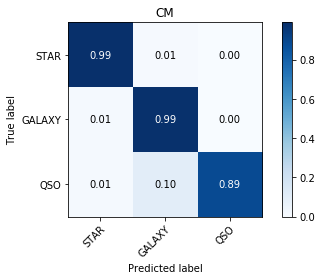

In [11]:
plot_confusion_matrix(y_true, y_pred, ['STAR','GALAXY','QSO'],
                          normalize=1,title='CM')